In [1]:
using DrWatson 
@quickactivate projectdir()

In [2]:
include(srcdir("rdpg.jl"))
import Main.rdpg
using PersistenceDiagrams, Pipe, Plots, ProgressMeter, Random, Ripserer, Statistics, StatsBase

In [3]:
function generate_sbm(n, k, p, r)
    f = (x, y) -> r + p * (x == y)
    Z = rand(1:k, n)
    return rdpg.Adjacency(f, Z)
end

function scale(X)
    return StatsBase.standardize(ZScoreTransform, X, dims=1)
end

function subsample(X, a=0.75)
    sample(X |> rdpg.m2t, round(Int, size(X, 1)^a ), replace=false )
end

function diagram(Xn; dim_max=0)
    ripserer(Xn |> Alpha, dim_max=dim_max)
end

diagram (generic function with 1 method)

In [4]:
p, r = 0.8, 0.1
clust = 3
repeats = 2
order = 1
d = 2

N = [100, 500, 1000]
ϵ = [0.5:0.5:3...]
n = length(ϵ);

In [5]:
with_eps    = [zeros(repeats, n) for _ in eachindex(N)];
without_eps = [zeros(repeats, n) for _ in eachindex(N)];

prog = ProgressMeter.Progress(convert(Int, n * repeats * length(ϵ)))

for j in eachindex(N)
    A = generate_sbm(N[j], clust, p, r)
    X, _, _ = rdpg.spectralEmbed(A, d=d, scale=false)
    X_norm = scale(X)
    DX = diagram(X |> subsample, dim_max=order)
    DX_norm = diagram(X_norm |> subsample, dim_max=order)

    for i in 1:n, k in 1:repeats
            
        A1 = rdpg.edgeFlip(A, ϵ=ϵ[i])            
        X1, _ = rdpg.spectralEmbed(A1, d=d, scale=false)
        X1_norm = scale(X1)
        D1_norm = diagram(X1_norm |> subsample, dim_max=order)
        without_eps[j][k, i] = Bottleneck()(DX_norm, D1_norm)

        A2 = (A1 .- rdpg.τ(ϵ[i])) ./ rdpg.σ(ϵ[i])^2
        X2, _ = rdpg.spectralEmbed(A2, d=d, scale=false)
        D2 = diagram(X2 |> subsample, dim_max=order)
        with_eps[j][k, i] = Bottleneck()(DX, D2)
            
        next!(prog)
    end
end

Progress:  50%|████████████████████▌                    |  ETA: 0:00:41

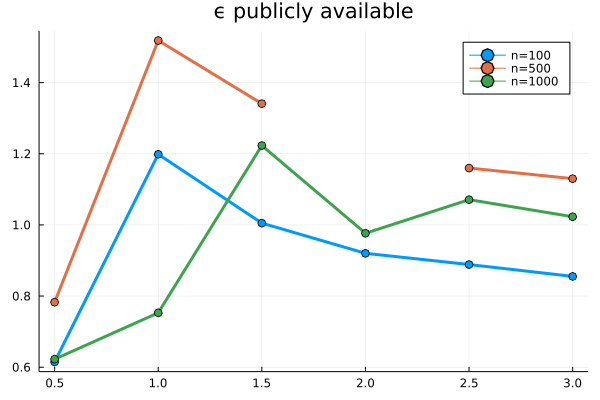

In [7]:
plt1 = plot(title="ϵ publicly available")
for k in eachindex(N)
    plot!(plt1, ϵ,
        with_eps[k] |> eachcol .|> skipmissing .|> mean,
        # ribbon = with_eps[k] |> eachcol .|> skipmissing .|> std,
        marker=:o,
        label="n=$(N[k])",
        lw=3, fillapha=0.01,
    )
end
plt1

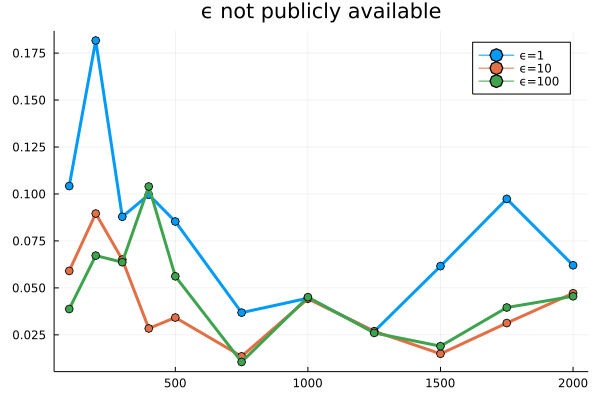

In [61]:
plt2 = plot(title="ϵ not publicly available")
for k in eachindex(N)
    plot!(plϵ       without_eps[k] |> eachcol .|> skipmissing .|> minimum,
        #ribbon = without_eps[k] |> eachcol .|> skipmissing .|> std,
        marker=:o,
        label="n=$(N[k])",
        lw=3, fillapha=0.01,
    )
end

plt2

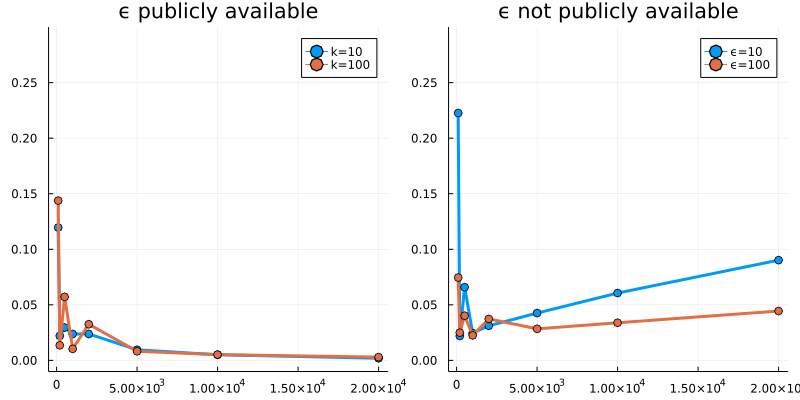

In [38]:
lim = (-0.010, 0.3)
plot(plot(plt1, ylim=lim), plot(plt2, ylim=lim), size=(800, 400))

In [ ]:
#savefig(plt1, plotsdir("comparisons/subsample-with-eps.svg"))

In [ ]:
#savefig(plt2, plotsdir("comparisons/subsample-without-eps.svg"))

In [ ]:
#savefig(plotsdir("comparisons/subsample-with-eps.svg"))